In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import scienceplots as scp

import numpy as np
import torch

matplotlib.rcParams['figure.figsize'] = (20, 6)

from main import main, parse_args

from argparse import Namespace
from utils.plotting import plot_change_responses, plot_trial_responses, plot_omission_responses, plot_sequence_responses
from utils.analysis import process_outputs, get_change_responses, get_omission_responses

import os

import warnings
warnings.filterwarnings('ignore')

SCRATCH = "."

In [9]:
def load_results_files(directory, prefix):
    # Ensure directory exists
    if not os.path.isdir(directory):
        print(f"Error: {directory} is not a valid directory.")
        return {}

    # Get list of files in directory
    files = os.listdir(directory)
    # Filter files by prefix and ending with '.pt'
    torch_files = [file for file in files if file.startswith(prefix)]

    args = None

    change_responses = {"familiar": {}, "novel": {}, "familiar_means":{}, "novel_means": {}}
    omission_responses = {"familiar": {}, "novel": {}}
    training_progress = {}
    for i, file in enumerate(torch_files):
        file_path = os.path.join(directory, file)
        try:
            # Load Torch file
            data = torch.load(file_path, map_location='cpu')
            # Concatenate tensors along the first axis

            if args is None:
                args = data['args']

            # first for change responses
            for key in data["change_responses"]["familiar"].keys():
                fam_value = data["change_responses"]["familiar"][key]
                nov_value = data["change_responses"]["novel"][key]
                fam_mean = data["change_responses"]["familiar_means"][key]
                nov_mean = data["change_responses"]["novel_means"][key]
                if key not in change_responses["familiar"]:
                    change_responses["familiar"][key] = fam_value
                    change_responses["novel"][key] = nov_value
                    change_responses["familiar_means"][key] = fam_mean
                    change_responses["novel_means"][key] = nov_mean
                else:
                    change_responses["familiar"][key] = torch.cat([change_responses["familiar"][key], fam_value])
                    change_responses["novel"][key] = torch.cat([change_responses["novel"][key], nov_value])
                    change_responses["familiar_means"][key] = torch.cat([change_responses["familiar_means"][key], fam_mean])
                    change_responses["novel_means"][key] = torch.cat([change_responses["novel_means"][key], nov_mean])
            
            # now for omission responses
            for key in data["omission_responses"]["familiar"].keys():
                fam_value = data["omission_responses"]["familiar"][key]
                nov_value = data["omission_responses"]["novel"][key]
                #fam_mean = data["omission_responses"]["familiar_means"][key]
                #nov_mean = data["omission_responses"]["novel_means"][key]
                if key not in omission_responses["familiar"]:
                    omission_responses["familiar"][key] = fam_value
                    omission_responses["novel"][key] = nov_value
                    #omission_responses["familiar_means"][key] = fam_mean
                    #omission_responses["novel_means"][key] = nov_mean
                else:
                    omission_responses["familiar"][key] = torch.cat([omission_responses["familiar"][key], fam_value])
                    omission_responses["novel"][key] = torch.cat([omission_responses["novel"][key], nov_value])
                    #omission_responses["familiar_means"][key] = torch.cat([omission_responses["familiar_means"][key], fam_mean])
                    #omission_responses["novel_means"][key] = torch.cat([omission_responses["novel_means"][key], nov_mean])
            
            # finally training progress
            for key in data['training_progress'].keys():
                if key not in training_progress:
                    training_progress[key] = [data['training_progress'][key]]
                else:
                    training_progress[key] += [data['training_progress'][key]]

            print(f"Loaded {i + 1}/{len(torch_files)} files", end='\r')
        except Exception as e:
            print(f"Error loading {file}: {str(e)}")
    
    training_progress = {k: np.stack(v) for k, v in training_progress.items()}
    
    return args, change_responses, omission_responses, training_progress

In [24]:
args, adaptation_change, adaptation_omission, adaptation_progress = load_results_files(f"{SCRATCH}/results/adaptation_baseline", "ad")
args = Namespace(**args)

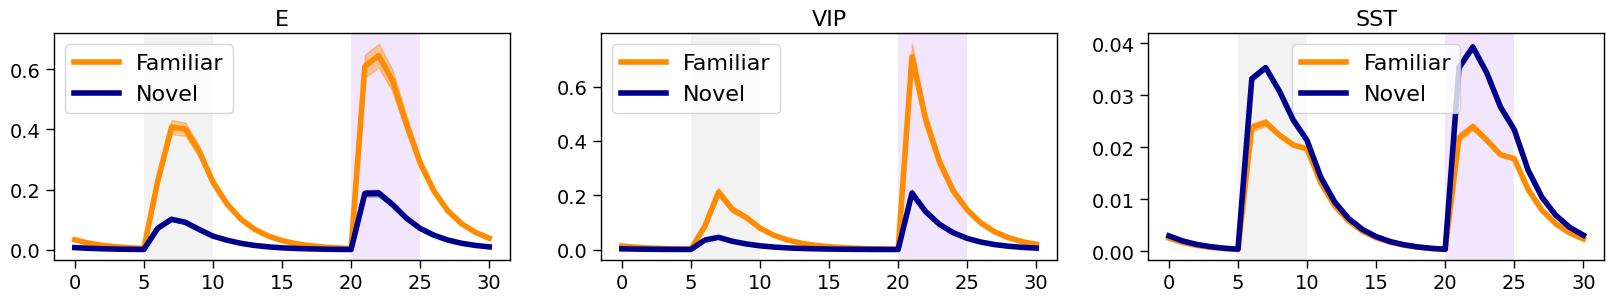

In [25]:
##### plot responses around image change

with plt.style.context(['nature', 'notebook']):
        
    adaptation_change_fig = plt.figure(figsize=(20, 10))
    plt.tight_layout(pad=10, h_pad=5)

    for i, pop in enumerate(adaptation_change['familiar'].keys()):
        ax = plt.subplot(3, 3, i+1)
        plot_trial_responses(args, ax, adaptation_change['familiar'][pop], adaptation_change['novel'][pop], normalize=False)
        ax.set_title(f"{pop}")
        ax.legend()

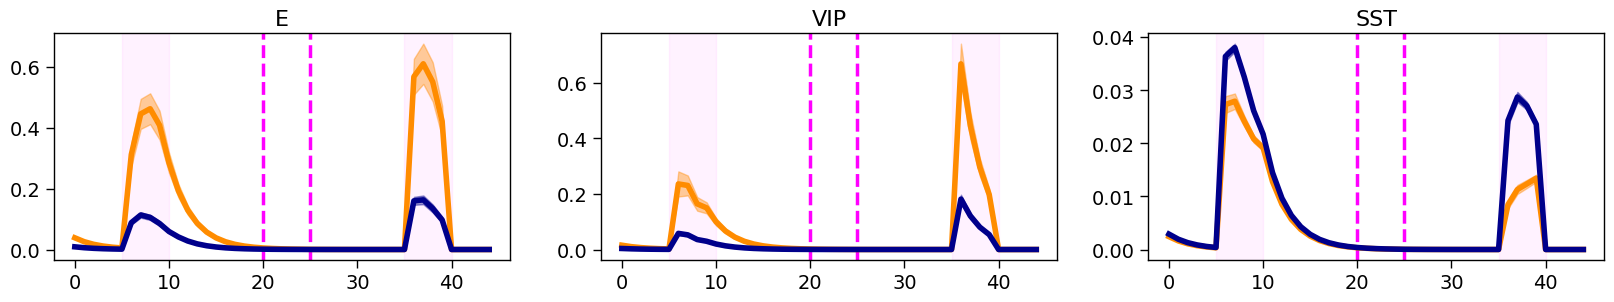

In [26]:
##### plot responses around omissions

with plt.style.context(['nature', 'notebook']):
    
    adaptation_omission_fig = plt.figure(figsize=(20, 10))
    plt.tight_layout(pad=10, h_pad=5)

    for i, pop in enumerate(adaptation_omission['familiar'].keys()):
        ax = plt.subplot(3, 3, i+1)
        plot_trial_responses(args, ax, adaptation_omission['familiar'][pop], adaptation_omission['novel'][pop], trial_mode='omission', normalize=False)
        _ = ax.set_title(f"{pop}")

(0.0, 1.0)

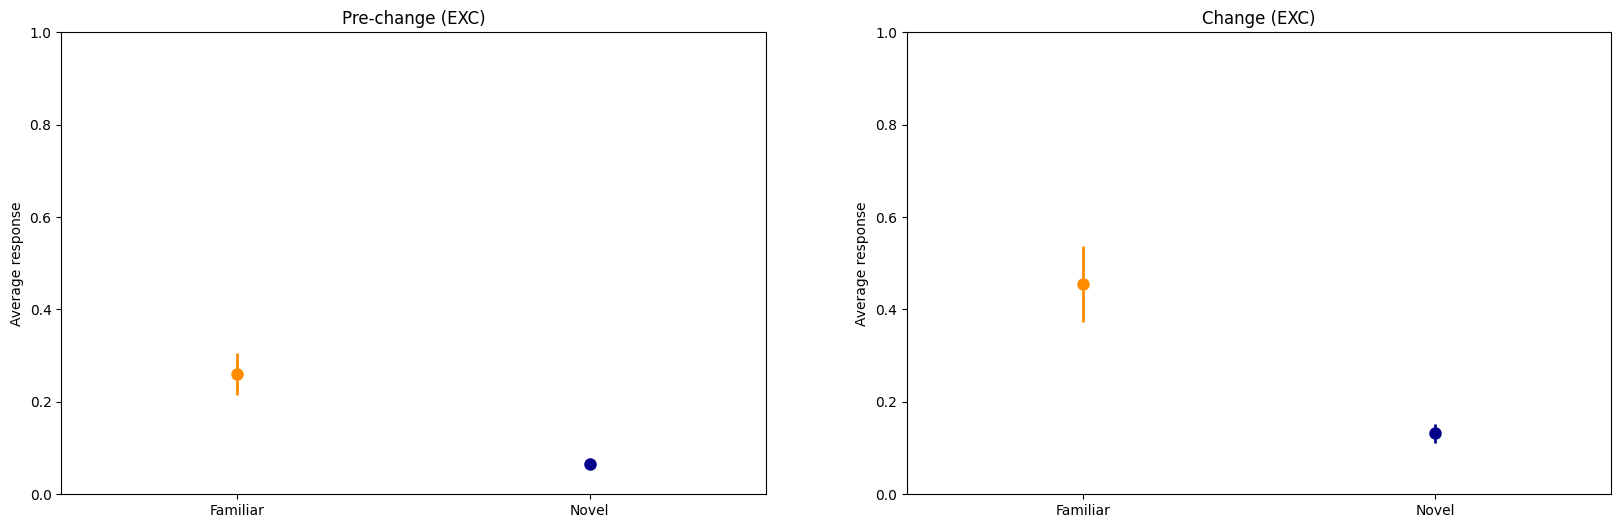

In [27]:
from utils.plotting import raincloud_plot, plot_confidence_intervals

sq = 3

pre_fam = adaptation_change['familiar_means']['E'][..., 0].detach()
change_fam = adaptation_change['familiar_means']['E'][..., 1].detach()
pre_nov = adaptation_change['novel_means']['E'][..., 0].detach()
change_nov = adaptation_change['novel_means']['E'][..., 1].detach()

exp_ax1 = plt.subplot(1, 2, 1)
plot_confidence_intervals(exp_ax1, pre_fam.mean(0).numpy(), pre_nov.mean(0).numpy(), alpha=0.05)
plt.title('Pre-change (EXC)')
plt.ylim([0., 1.])

exp_ax2 = plt.subplot(1, 2, 2)
plot_confidence_intervals(exp_ax2, change_fam.mean(0).numpy(), change_nov.mean(0).numpy(), alpha=0.05)
plt.title('Change (EXC)')
plt.ylim([0., 1.])

(0.0, 0.6)

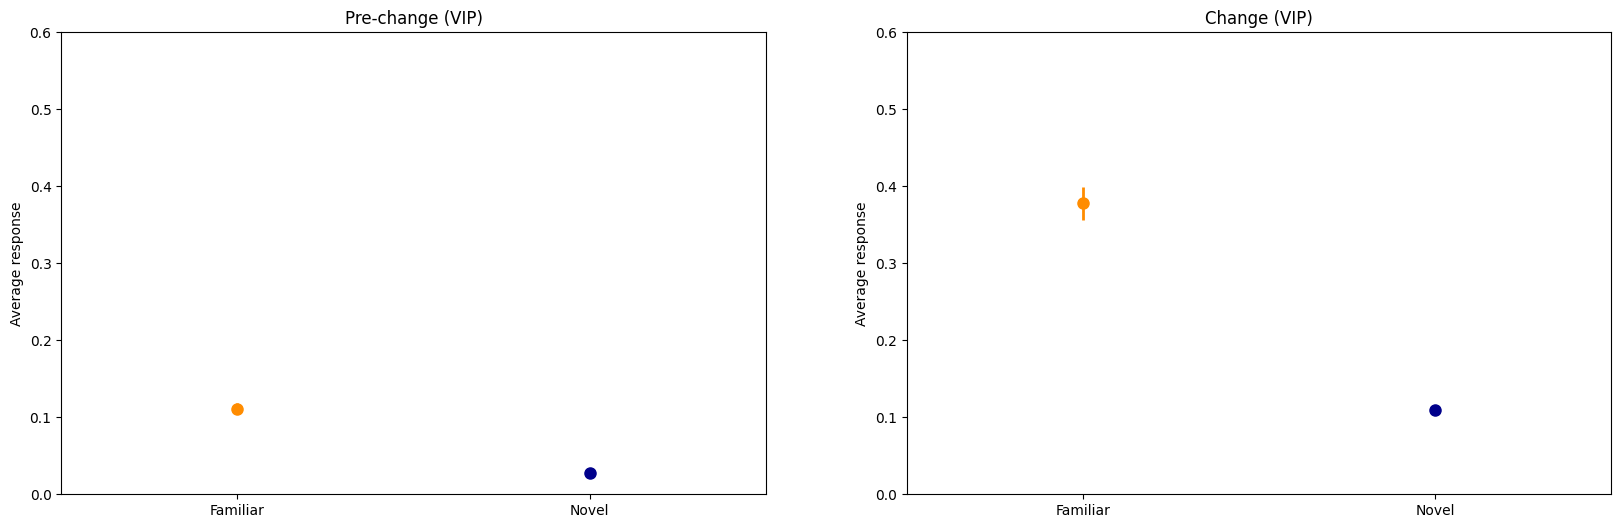

In [20]:
from utils.plotting import raincloud_plot, plot_confidence_intervals

sq = 3

pre_fam = adaptation_change['familiar_means']['VIP'][..., 0].detach()
change_fam = adaptation_change['familiar_means']['VIP'][..., 1].detach()
pre_nov = adaptation_change['novel_means']['VIP'][..., 0].detach()
change_nov = adaptation_change['novel_means']['VIP'][..., 1].detach()

exp_ax1 = plt.subplot(1, 2, 1)
plot_confidence_intervals(exp_ax1, pre_fam.mean(0).numpy(), pre_nov.mean(0).numpy(), alpha=0.05)
plt.title('Pre-change (VIP)')
plt.ylim([0., 0.6])

exp_ax2 = plt.subplot(1, 2, 2)
plot_confidence_intervals(exp_ax2, change_fam.mean(0).numpy(), change_nov.mean(0).numpy(), alpha=0.05)
plt.title('Change (VIP)')
plt.ylim([0., 0.6])